## Introduction
The goal of this analysis is to find customer segementation clusters in order to better market to customers for credit cards. The motivation behind this is that not every customer is in the same place financially and may not be a good fit for all cards. Thus, if we can customize marketing to their "customer type" (i.e. the cluster they belong to), we can be more profitable and have higher satisfaction.

This task requires unsupervised learning because we have no indication of the group/customer segment that each customerID in the dataset belongs to. We want a clustering algorithm to find this for us.    

Original data source: https://www.kaggle.com/arjunbhasin2013/ccdata

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [0]:
credit = pd.read_csv('https://raw.githubusercontent.com/mdibble2/Projects/master/Unsupervised%20ML/Clustering%20Capstone/CC%20GENERAL.csv')
credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Exploration and Cleaning
Comprised of 4 elements (in tandem with visualizations): data format/distribution, null values, outliers, and feature engineering

In [0]:
credit.shape

(8950, 18)

**1. Data Format/Data Distributions**

In [0]:
credit.info()
#dtypes make sense for all the variables 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

8950 observations, and all data is numerical

In [0]:
credit.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


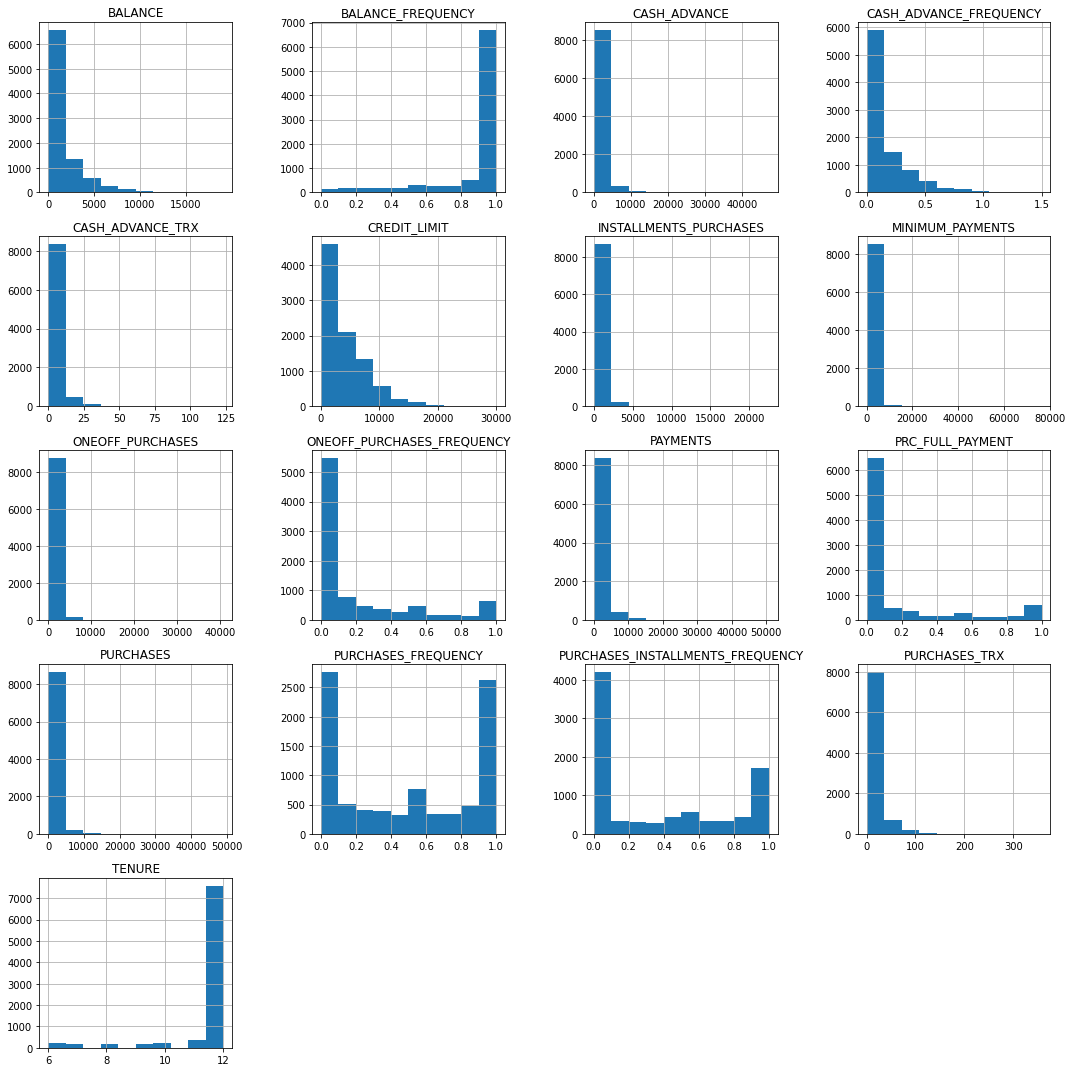

In [0]:
credit.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

* Lots of distributions are skewed right, so there may be outliers that need to be dealt with later to ensure we can model the data.     

* The PURCHASES_FREQUENCY variable shows that the customers using these credit cards are mostly either using them infrequently or very frequently--not a lot of customers are in the middle. Could be a potential cluster split.      

* Tenure is mostly around 11 or 12, not sure if this is months or years? Would makes sense if it's months and they cut it off so it's only people who have had a card less than a year.

* 75% of customers have less than 1,110 purchases during the last 6 months


In [0]:
credit.CUST_ID.unique
#CUST_ID is unique ID for each row

<bound method Series.unique of 0       C10001
1       C10002
2       C10003
3       C10004
4       C10005
         ...  
8945    C19186
8946    C19187
8947    C19188
8948    C19189
8949    C19190
Name: CUST_ID, Length: 8950, dtype: object>

In [0]:
credit.duplicated().sum()
credit.drop
#no duplicate observations

<bound method DataFrame.drop of      CUST_ID      BALANCE  ...  PRC_FULL_PAYMENT  TENURE
0     C10001    40.900749  ...          0.000000      12
1     C10002  3202.467416  ...          0.222222      12
2     C10003  2495.148862  ...          0.000000      12
3     C10004  1666.670542  ...          0.000000      12
4     C10005   817.714335  ...          0.000000      12
...      ...          ...  ...               ...     ...
8945  C19186    28.493517  ...          0.500000       6
8946  C19187    19.183215  ...          0.000000       6
8947  C19188    23.398673  ...          0.250000       6
8948  C19189    13.457564  ...          0.250000       6
8949  C19190   372.708075  ...          0.000000       6

[8950 rows x 18 columns]>

**2. Null Values**

In [0]:
credit.isna().sum()/len(credit)

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.000112
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    0.034972
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

Credit limit is the limit of the credit card for the customer. Is it possible that the null values represent customers who have no limit? Or customers deactivated their card?

In [0]:
credit[credit.CREDIT_LIMIT.isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


This customer had purchases? Did anyone else have 0 purchases?

In [0]:
credit[credit.PURCHASES==0]
#2,044 rows out of ~ 9,000 customers did not have any purchases in these 6 months... something to keep in mind
#inactive card holders could be a cluster

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1,C10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.0,0.0,0.0,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
14,C10015,2772.772734,1.000000,0.0,0.0,0.0,346.811390,0.0,0.0,0.0,0.083333,1,0,3000.0,805.647974,989.962866,0.000000,12
16,C10017,2072.074354,0.875000,0.0,0.0,0.0,2784.274703,0.0,0.0,0.0,0.250000,3,0,3000.0,391.974562,376.579631,0.000000,8
24,C10025,5368.571219,1.000000,0.0,0.0,0.0,798.949863,0.0,0.0,0.0,0.363636,4,0,6000.0,1422.726707,1657.002877,0.000000,11
35,C10036,1656.350781,1.000000,0.0,0.0,0.0,99.264367,0.0,0.0,0.0,0.083333,1,0,1800.0,351.500199,634.569311,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,C19161,1055.087681,0.666667,0.0,0.0,0.0,1820.116200,0.0,0.0,0.0,0.333333,2,0,2000.0,54.795084,233.229870,0.000000,6
8929,C19170,371.527312,0.333333,0.0,0.0,0.0,1465.407927,0.0,0.0,0.0,0.166667,5,0,1500.0,0.000000,NaN,0.000000,6
8937,C19178,163.001629,0.666667,0.0,0.0,0.0,274.440466,0.0,0.0,0.0,0.166667,3,0,1000.0,117.738787,60.792450,0.000000,6
8938,C19179,78.818407,0.500000,0.0,0.0,0.0,1113.186078,0.0,0.0,0.0,0.166667,7,0,1200.0,1397.770131,21.821194,0.333333,6


In [0]:
#I'm going to drop the row with an N/A for credit limit since it is a single observation, and it's not likely that their limit was infinite
credit_clean = credit.drop(5203,axis=0)

In [0]:
#other variable with null values is minimum payments
#minimum payments is defined as "Minimum amount of payments made by user" (in last 6 months)
credit_clean[credit_clean.MINIMUM_PAYMENTS.isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,C19185,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


In [0]:
credit_clean[(credit_clean.MINIMUM_PAYMENTS.isna()) & (credit_clean.PAYMENTS==0)].shape
#of the 313 rows with min payments = null, 240 rows made $0 in payments in this time span

(240, 18)

In [0]:
#reclassify these 240 as min_payment = 0
indicies = list(credit_clean[(credit_clean.MINIMUM_PAYMENTS.isna()) & (credit_clean.PAYMENTS==0)].index)

credit_clean.loc[(credit_clean.MINIMUM_PAYMENTS.isna()) & (credit_clean.PAYMENTS==0), 'MINIMUM_PAYMENTS'] = 0

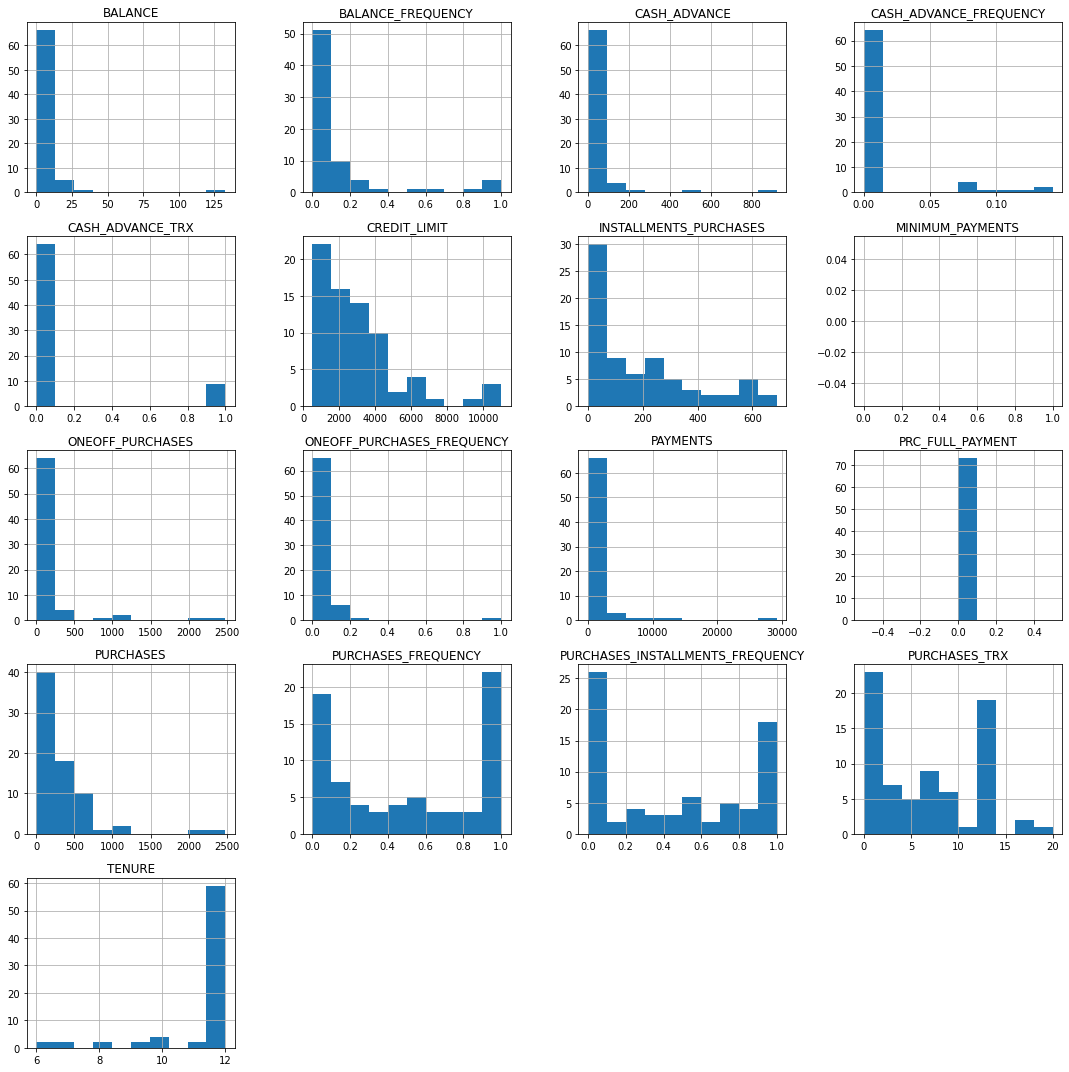

73 rows included


In [0]:
#for the rest of values...
credit_clean[credit_clean.MINIMUM_PAYMENTS.isna()].hist(figsize=(15,15)); #show distributions where min payments is null
plt.tight_layout()
plt.show()
#are these distributions different than the distributions from the entire dataset?
print(credit_clean[credit_clean.MINIMUM_PAYMENTS.isna()].shape[0],'rows included')

* balance frequency is much lower--balance is updated less frequently 
  * is it possible that their balance wasn't updated in the entire 6  months but they payed anyway?
* PRC full payment (percetage of full payment paid by user) is close to zero--it's a little more spread out in the original dataset

In [0]:
#only 73 rows, seems safe to fill values with the median
credit_clean.loc[credit_clean.MINIMUM_PAYMENTS.isna(),'MINIMUM_PAYMENTS'] = credit_clean.MINIMUM_PAYMENTS.median()


**3. Outliers**

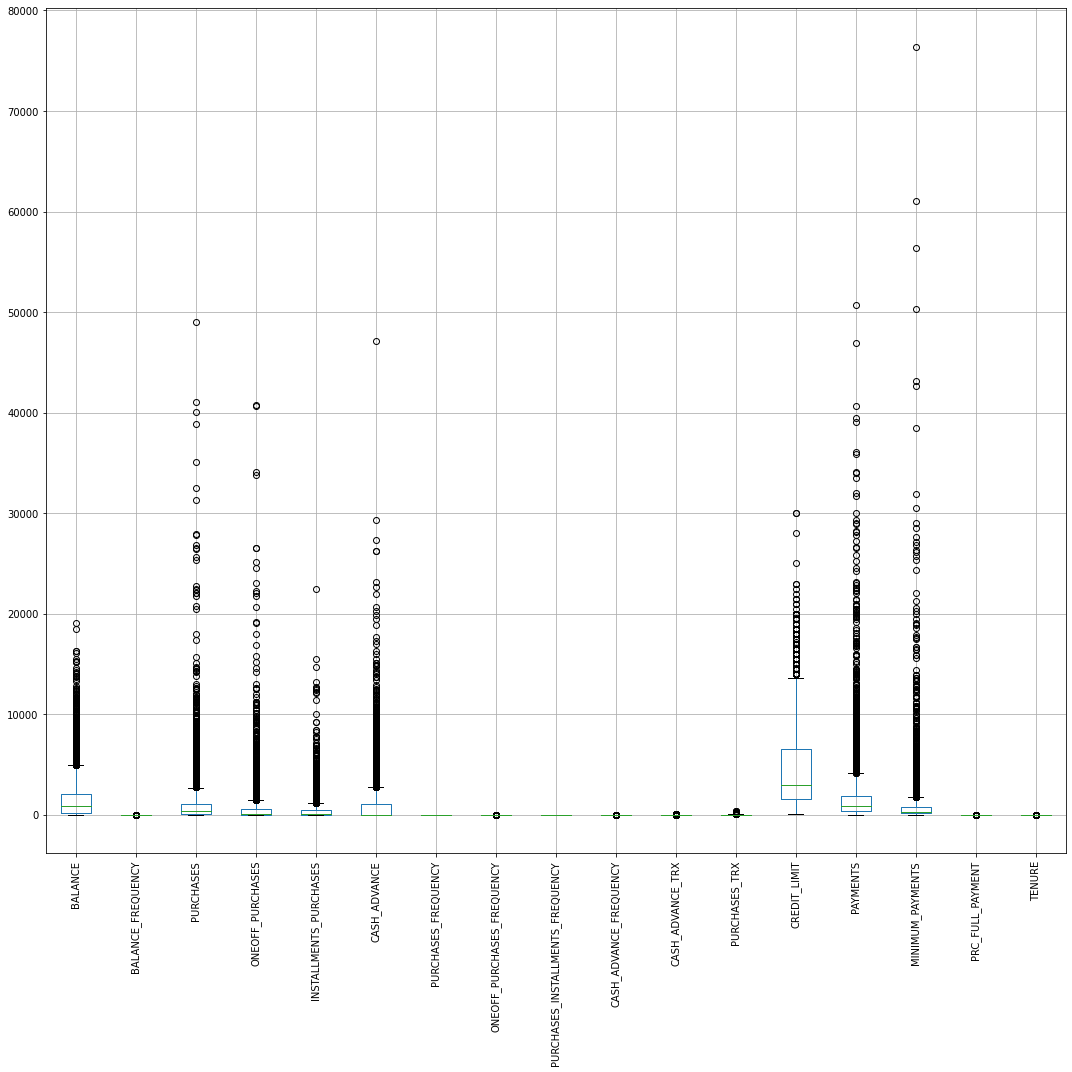

In [0]:
credit_clean.boxplot(figsize=(15,15),rot=90)
plt.tight_layout()
plt.show()

We already know from histograms that many distributions are skewed right, just due to the nature of the data (there are less big spenders/very frequent users).    
However, MINIMUM_PAYMENTS and CASH_ADVANCE have some very extreme outliers in the boxplot above. Let's look closer at those distributions and the observations.

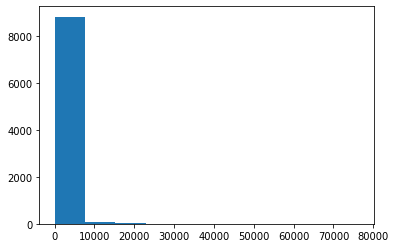

In [0]:
plt.hist(credit_clean.MINIMUM_PAYMENTS)
plt.show()

In [0]:
credit_clean[credit_clean.MINIMUM_PAYMENTS > 60000]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4376,C14499,10571.411070,1.0,7739.48,0.0,7739.48,0.000000,1.0,0.0,1.0,0.000000,0,44,8000.0,2688.447014,76406.20752,0.0,12
7132,C17325,9024.812044,1.0,0.00,0.0,0.00,2750.442399,0.0,0.0,0.0,0.083333,2,0,9000.0,302.484224,61031.61860,0.0,12


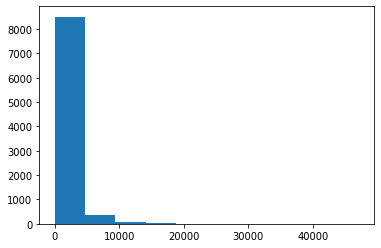

In [0]:
plt.hist(credit_clean.CASH_ADVANCE)
plt.show()

In [0]:
credit_clean[credit_clean.CASH_ADVANCE > 30000]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


These observations do not appear to be errors, might come back and re-evaluate excluding them if model performance is low

**4. Feature Engineering**

In [0]:
#standardize variables before using dimension reduction or clustering
from sklearn.preprocessing import StandardScaler
X = credit_clean.drop(axis=1,columns='CUST_ID')
X_std = StandardScaler().fit_transform(X)

## Dimensionality Reduction

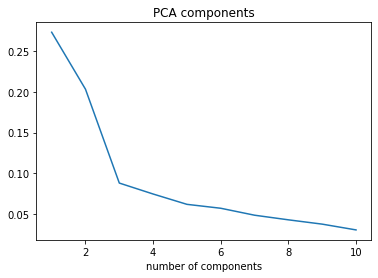

[0.27298502 0.20317663 0.08821402 0.07478978 0.06213303 0.05733518
 0.04881999 0.04315878 0.03787951 0.03080103]


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X_std)

plt.plot(np.arange(1,11),pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.title('PCA components')
plt.show()

print(pca.explained_variance_ratio_)

In [0]:
pca.explained_variance_ratio_.cumsum()

array([0.27298502, 0.47616165, 0.56437567, 0.63916545, 0.70129848,
       0.75863366, 0.80745366, 0.85061243, 0.88849194, 0.91929297])

First 7 principle components explain 81% of the variance

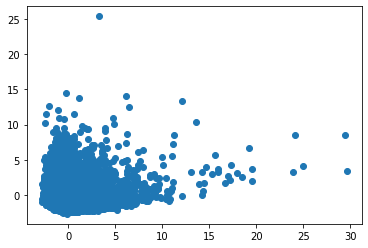

In [0]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.show()

This visualization shows that the data does not appear to be linearly separable in 2D, so I will try working with UMAP dimensionality reduction

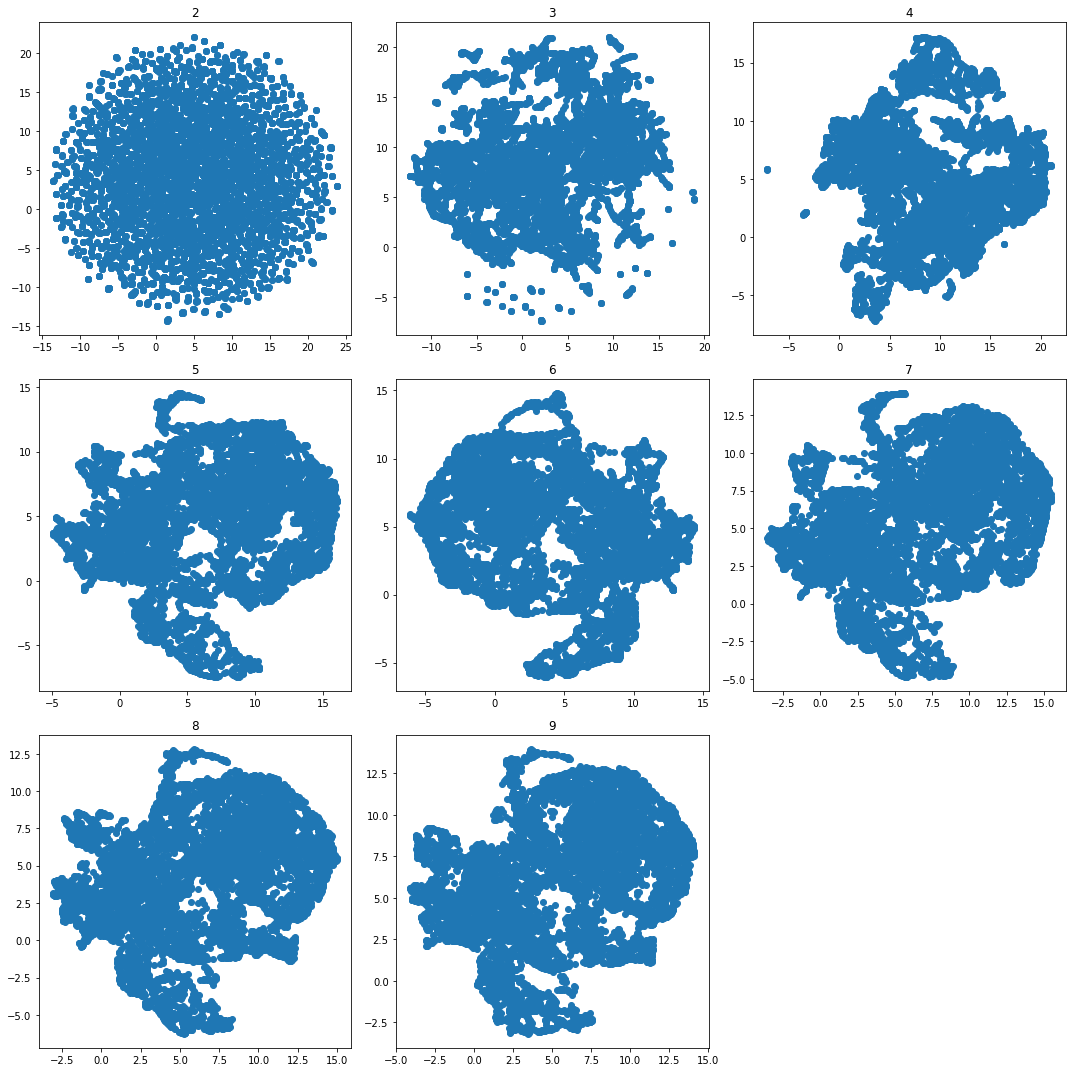

In [0]:
import umap
plt.figure(figsize=(15,15))
for i in range (2,10): #tune n_neighbors parameter 
  umap_comp = umap.UMAP(n_neighbors=i,min_dist=.3,metric='correlation').fit_transform(X_std)
  plt.subplot(3,3,i-1)
  plt.scatter(umap_comp[:,0],umap_comp[:,1])
  plt.title(str(i))
plt.tight_layout()
plt.show()

UMAP with n_neighbors = 3 or 4 shows the most distinct clusters. I will use 4 since it does not have random points on the left side that are outside of the cluster like the graph of n_neighbors = 3 does.

## Clustering Models

**K-Means**

In [0]:
#split standardized X into test and train 
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_std,random_state = 33)

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
sil = []
cv_scores = []

for i in range(2,21): #iterating k values to find the one with highest silhoutte score
  cluster = KMeans(n_clusters=i) 
  cluster_fit = cluster.fit(X_train)

  ypred = cluster.predict(X_test) 
  sil.append(silhouette_score(X_test,ypred))


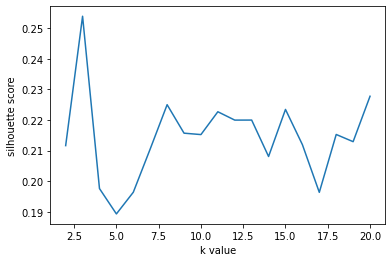

In [0]:
plt.plot(range(2,21),sil)
plt.xlabel('k value')
plt.ylabel('silhouette score')
plt.show()

In [0]:
#checking where the peak value for silhouette score is 
sil[:3]

[0.21162323684486928, 0.2538879630577864, 0.19759175002787088]

k=3 gives the highest silhouette score, which matches my guess from the UMAP dimensionality reduction!

In [0]:
  #get labels for prediction
  cluster = KMeans(n_clusters=3) 
  cluster_fit = cluster.fit(X_train)

  ypred = cluster.predict(X_test) 

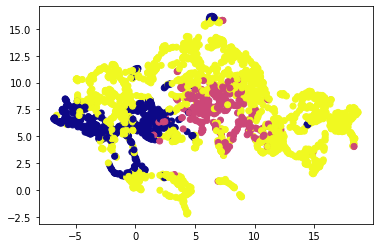

In [0]:
#visualizing the predicted clusters in 2D
umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation',random_state=33).fit_transform(X_test)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=ypred,cmap='plasma')
plt.show()

Classes are not exactly separated

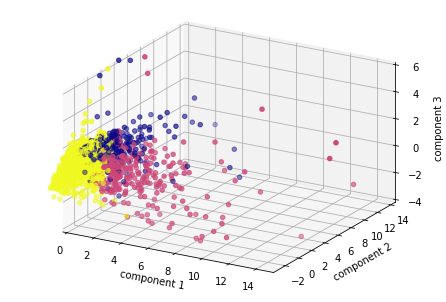

In [0]:
#try using PCA to visualize and plot in 3D 

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_test)

X = X_pca[:,0]
Y = X_pca[:,1]

Z = X_pca[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X, Y, Z,c=ypred,cmap='plasma')
ax.set_proj_type('ortho')

ax.set_xlabel('component 1')
ax.set_xlim(0,15)
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
ax.set_zlim(-4,6)
plt.show()

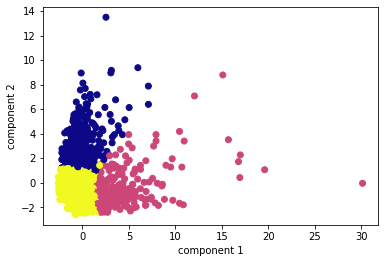

In [0]:
#view in 2D on X,Y axis
plt.scatter(X,Y,c=ypred,cmap='plasma')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

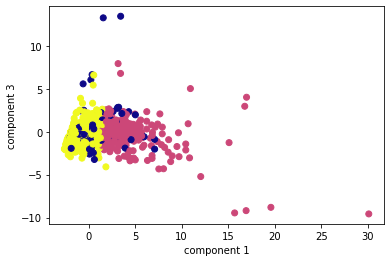

In [0]:
#view in 2D on X,Z axis
plt.scatter(X,Z,c=ypred,cmap='plasma')
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.show()

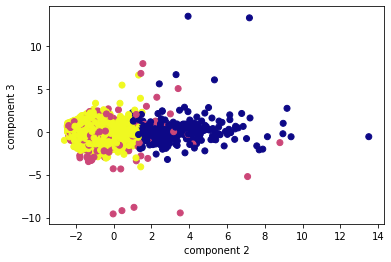

In [0]:
#view in 2D on Y,Z axis
plt.scatter(Y,Z,c=ypred,cmap='plasma')
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.show()

clusters look nice on the X-Y axis, but do not completely follow the assumptions of k means on other axis views. X-Y axis is what matters most though since the first two components contain the most information about the original variables


**Hierarchical Clustering**

In [0]:
from sklearn.cluster import AgglomerativeClustering 

#CANNOT FIGURE OUT HOW TO FIT TRAINING DATA AND PREDICT WITH TEST DATA
# .PREDICT IS NOT INCLUDED FOR THIS MODEL IN SKLEARN
model1 = AgglomerativeClustering(linkage='complete',affinity='euclidean')
y_comp = model1.fit_predict(X_std) #used all the X data

y_ward = AgglomerativeClustering(linkage='ward',affinity='euclidean').fit_predict(X_std)
y_avg = AgglomerativeClustering(linkage='average',affinity='euclidean').fit_predict(X_std)

In [0]:
print('silhouette score')
print('complete:', silhouette_score(X_std,y_comp))
print('ward:', silhouette_score(X_std,y_ward))
print('average:' ,silhouette_score(X_std,y_avg))

silhouette score
complete: 0.7865405019119251
ward: 0.18136106307278327
average: 0.8408033166683467


Complete and Average linkage methods perform much better on the silhouette score metric; All three hierarchical methods outperform K Means

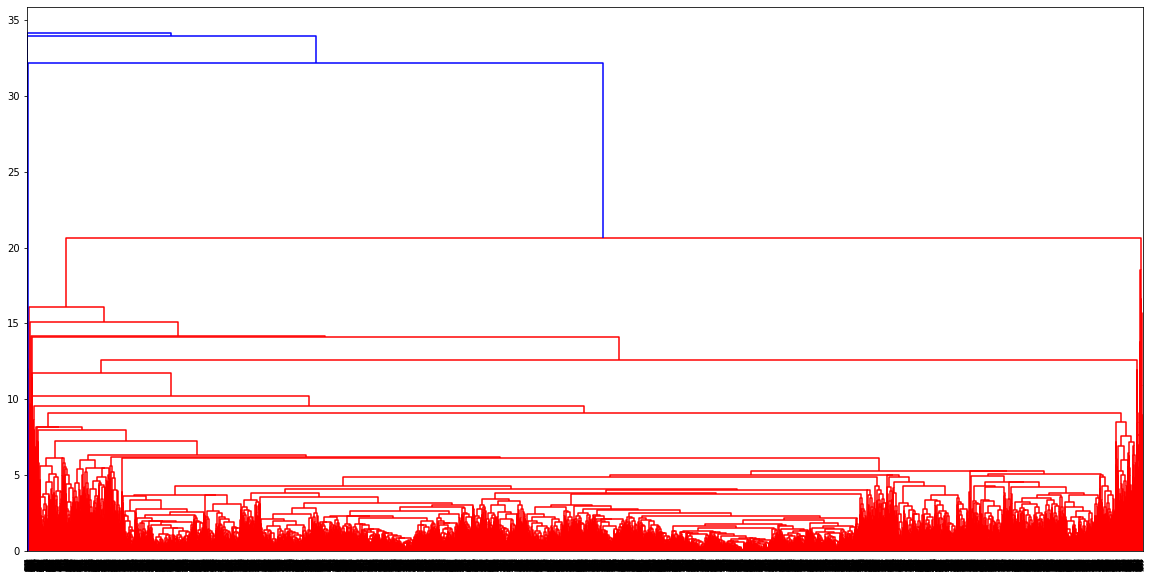

In [0]:
#visualize hierarchy that the algorithm found
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,10))
dendrogram(linkage(X_train, method='average'))
plt.show();

From this, I do not think the data clusters are hierarchical in nature

In [0]:
#how many clusters did it find?
hierarchy = AgglomerativeClustering(linkage='average',affinity='euclidean').fit(X_std)
hierarchy.n_clusters

2

In [0]:
#did the complete method find more clusters?
hierarchy = AgglomerativeClustering(linkage='complete',affinity='euclidean').fit(X_train)
hierarchy.n_clusters

2

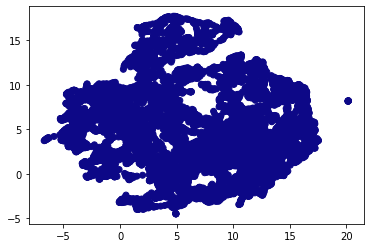

In [0]:
#visualizing the clusters in 2D for best method (average)
umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation').fit_transform(X_std)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=y_avg,cmap='plasma')
plt.show()

Hierarchical clustering found 2 clusters, but it appears that almost all points are labeled as the first cluster.  Hierarchical is **not** the best method

**DBSCAN Clustering**

DBSCAN does well with highly dense dataset with overlapping

In [0]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1,min_samples=2,metric='euclidean')
clusters = dbscan.fit_predict(X_std)

dbscan.fit(X_train).labels_.max()

156

In [0]:
#number of above clusters might be overfitting--try with higher min_samples
clusters = []
labels = []
for i in range (2,11):
  dbscan = DBSCAN(eps=3,min_samples=i,metric='euclidean')
  clusters.append(dbscan.fit_predict(X_std))
  labels.append(dbscan.fit(X_std).labels_.max())
  print(i,dbscan.fit(X_std).labels_.max())

2 13
3 5
4 3
5 0
6 0
7 0
8 0
9 0
10 0


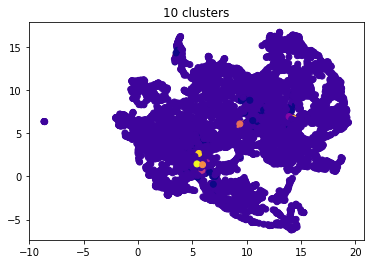

In [0]:
#visualize the cluster predictions for min_samples = 2,3,4

dbscan = DBSCAN(eps=3,min_samples=2,metric='euclidean')
y_label = dbscan.fit_predict(X_train)

umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation').fit_transform(X_train)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=y_label,cmap='plasma')
plt.title('10 clusters')
plt.show()

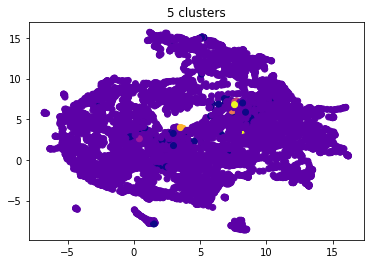

In [0]:
dbscan = DBSCAN(eps=3,min_samples=3,metric='euclidean')
y_label = dbscan.fit_predict(X_train)

umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation').fit_transform(X_train)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=y_label,cmap='plasma')
plt.title('5 clusters')
plt.show()

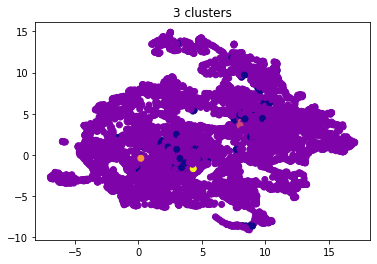

In [0]:
dbscan = DBSCAN(eps=3,min_samples=4,metric='euclidean')
y_label = dbscan.fit_predict(X_train)

umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation').fit_transform(X_train)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=y_label,cmap='plasma')
plt.title('3 clusters')
plt.show()

None of these separate the very well... maybe the three cluster solution is ok

In [0]:
#calc silhouette score for 3 cluster solution
silhouette_score(X_train,y_label)

0.39171897009539786

**GMM clustering** 

In [0]:
from sklearn.mixture import GaussianMixture
for i in range(2,11): 
  gmm_cluster = GaussianMixture(n_components=i)
  gmm_clusters = gmm_cluster.fit_predict(X_std)
  print(i,'clusters: ',silhouette_score(X_std,gmm_clusters))

2 clusters:  0.18453875228764252
3 clusters:  0.11274240503426197
4 clusters:  0.09763175582673346
5 clusters:  0.07237479919688831
6 clusters:  0.06234092314719489
7 clusters:  0.04380691561491593
8 clusters:  0.014572557834140848
9 clusters:  0.03628685977733736
10 clusters:  0.017230384571365227


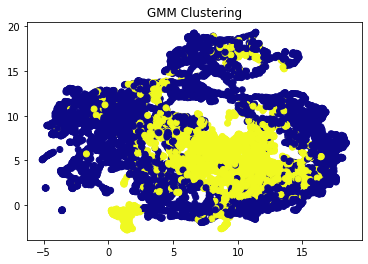

In [0]:
#visualize the 2 GMM clusters
umap_comp = umap.UMAP(n_neighbors=4,min_dist=.3,metric='correlation').fit_transform(X_std)
gmm_cluster = GaussianMixture(n_components=2)
gmm_clusters = gmm_cluster.fit_predict(X_std)
plt.scatter(umap_comp[:,0],umap_comp[:,1],c=gmm_clusters,cmap='plasma')
plt.title('GMM Clustering');


silhouette score of GMM is not as good as K means (.25), but the 2D graph shows decent clusters (better than DBSCAN or hierachical)

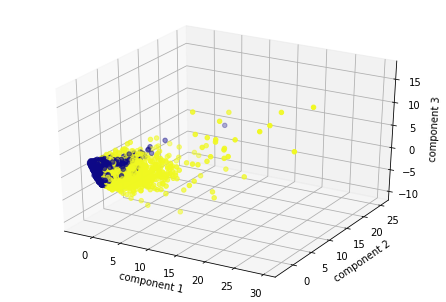

In [0]:
#try using PCA to visualize and plot in 3D 

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_std)

X = X_pca[:,0]
Y = X_pca[:,1]

Z = X_pca[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X, Y, Z,c=gmm_clusters,cmap='plasma')

ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.show()

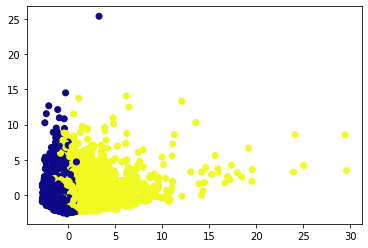

In [0]:
#visualize on X-Y axis
plt.scatter(X,Y,c=gmm_clusters,cmap='plasma');

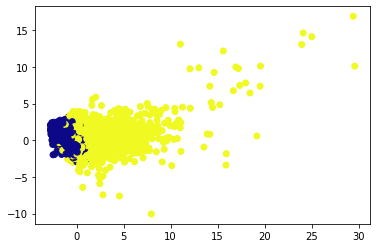

In [0]:
#visualize on X-Z axis
plt.scatter(X,Z,c=gmm_clusters,cmap='plasma');

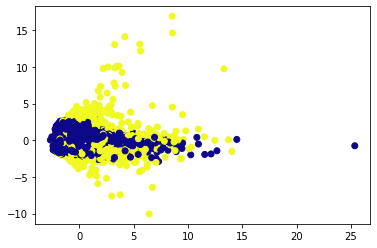

In [0]:
#visualize on Y-Z axis
plt.scatter(Y,Z,c=gmm_clusters,cmap='plasma');

Clusters look pretty good except on Y-Z axis

##Conclusion

K Means had the solution with the most meaning--clusters were relatively evenly sized and silhouette score was approximately .25. Hierarchical and DBSCAN clustering showed that the data points are all pretty similar, since hierarchical clustering found only 2 clusters and DBSCAN put most data points into the first cluster. Finally, GMM produced another viable solution, with a silhouette score of .19 and mostly separated clusters

Now I will evaluate K Means and GMM on their consistency to compare them further

In [0]:
#evaluate on consistency across sub-samples

#make df even number of rows first
X_std = pd.DataFrame(X_std).drop([0])
X_pca = pd.DataFrame(X_pca).drop([0])

X_half1, X_half2 = train_test_split(X_std,train_size=.5,random_state=4)
X_pcahalf1, X_pcahalf2 = train_test_split(X_pca,train_size=.5,random_state=4)

In [0]:
print(len(X_half1),len(X_half2))
print(len(X_pcahalf1),len(X_pcahalf2))

4474 4474
4474 4474


In [0]:
X_pcahalf1

,0,1,2
2693,-0.673996,2.470666,1.676595
3737,-1.003613,1.930634,0.714820
3880,-1.018723,1.090589,0.481350
7862,-1.614132,4.663076,-0.181152
8050,-0.849599,0.497429,-1.115141
...,...,...,...
457,0.227369,-1.231497,-0.313094
6018,0.599447,-0.126537,-0.025224
710,-0.858237,3.875413,0.080385
8367,-0.237163,-0.950926,1.856571


In [0]:
#K Means 

X_pcahalf1.reset_index(inplace=True,drop=True)
X_pcahalf2.reset_index(inplace=True,drop=True)
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()
pred = []

ypred['pca_f1' + '_sample' + str(1)] = X_pcahalf1.iloc[:, 0]
ypred['pca_f2' + '_sample' + str(1)] = X_pcahalf1.iloc[:, 1]

ypred['pca_f1' + '_sample' + str(2)] = X_pcahalf2.iloc[:, 0]
ypred['pca_f2' + '_sample' + str(2)] = X_pcahalf2.iloc[:, 1]
# Generate cluster predictions 
pred.append(KMeans(n_clusters=3,random_state=33).fit_predict(X_half1))
pred.append(KMeans(n_clusters=3,random_state=33).fit_predict(X_half2))

In [0]:
ypred

,pca_f1_sample1,pca_f2_sample1,pca_f1_sample2,pca_f2_sample2
0,-0.673996,2.470666,-1.651788,0.348980
1,-1.003613,1.930634,-0.203868,2.778940
2,-1.018723,1.090589,-0.886683,1.104560
3,-1.614132,4.663076,-1.591449,3.736314
4,-0.849599,0.497429,1.291777,3.451978
...,...,...,...,...
4469,0.227369,-1.231497,3.090525,3.570098
4470,0.599447,-0.126537,0.350173,-1.722235
4471,-0.858237,3.875413,-1.176392,-1.802185
4472,-0.237163,-0.950926,-1.484317,0.934281


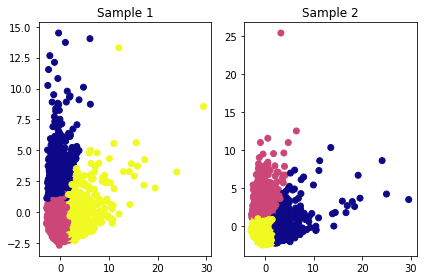

In [0]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(ypred.iloc[:,0],ypred.iloc[:,1],c=pred[0],cmap='plasma')
plt.title('Sample 1')
plt.subplot(1,2,2)
plt.scatter(ypred.iloc[:,2],ypred.iloc[:,3],c=pred[1],cmap='plasma')
plt.title('Sample 2')

plt.tight_layout()
plt.show()

In [0]:
#calc silhouette scores
print('sample 1:',silhouette_score(X_pcahalf1,pred[0]))
print('sample 2:',silhouette_score(X_pcahalf2,pred[1]))

sample 1: 0.38098481619922003
sample 2: 0.3743394692436827


Clusters are pretty consistent across 2 even random samples for K Means. Silhouette scores are very similar and reasonably high as well.

In [0]:
#make plots for GMM model
gmm_pred = []

gmm_pred.append(gmm_cluster.fit_predict(X_half1))
gmm_pred.append(gmm_cluster.fit_predict(X_half2))

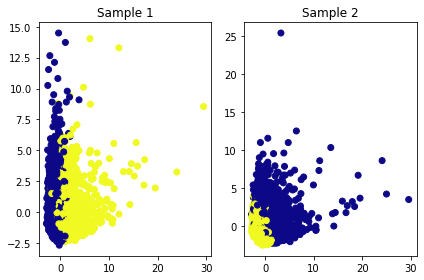

In [0]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(ypred.iloc[:,0],ypred.iloc[:,1],c=gmm_pred[0],cmap='plasma')
plt.title('Sample 1')
plt.subplot(1,2,2)
plt.scatter(ypred.iloc[:,2],ypred.iloc[:,3],c=gmm_pred[1],cmap='plasma')
plt.title('Sample 2')

plt.tight_layout()
plt.show()

In [0]:
#calc silhouette scores
print('sample 1:',silhouette_score(X_pcahalf1,gmm_pred[0]))
print('sample 2:',silhouette_score(X_pcahalf2,gmm_pred[1]))

sample 1: 0.2501523324736675
sample 2: 0.244029087535743


GMM model is also relatively consistent, but silhouette scores are not as high as K Means

**K Means is the best choice, but what do the clusters mean? How can the business use them?**

In [0]:
cluster = KMeans(n_clusters=3,random_state=10) 
cluster_fit = cluster.fit(X_train)

ypred = pd.Series(cluster.predict(X_test))

In [0]:
#add cluster labels to X_train
X_train, X_test = train_test_split(X_std,random_state = 33)
prediction_obs  = pd.concat([pd.DataFrame(X_test.reset_index(drop=True)),ypred],axis=1) #add cluster labels to the X_test dataframe

In [0]:

prediction_obs.rename(columns={0: "CLUSTER"},inplace=True)
#prediction_obs.drop(2237,inplace=True)
prediction_obs.iloc[:,17]

0       2
1       2
2       2
3       2
4       0
       ..
2232    1
2233    2
2234    1
2235    2
2236    2
Name: CLUSTER, Length: 2237, dtype: int32

In [0]:
#put into random forest and get feature importances

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10).fit(X_test.reset_index(drop=True),prediction_obs.iloc[:,17])

In [0]:
importances = pd.DataFrame([list(credit_clean.columns[1:]),rf.feature_importances_]).T
importances.columns = ['Variable','Importance']
importances.sort_values(['Importance'],ascending=False)

,Variable,Importance
5,CASH_ADVANCE,0.143418
2,PURCHASES,0.133598
10,CASH_ADVANCE_TRX,0.114313
9,CASH_ADVANCE_FREQUENCY,0.108419
0,BALANCE,0.0909654
11,PURCHASES_TRX,0.0882835
13,PAYMENTS,0.0581901
3,ONEOFF_PURCHASES,0.0522794
7,ONEOFF_PURCHASES_FREQUENCY,0.0472123
12,CREDIT_LIMIT,0.0450733


In [0]:
X_train, X_test = train_test_split(credit_clean,random_state = 33)

X_test_pred = pd.concat([pd.DataFrame(X_test),prediction_obs.iloc[:,17]],axis=1)

In [0]:
data = X_test_pred[['PURCHASES','CASH_ADVANCE','CASH_ADVANCE_TRX','CLUSTER']]

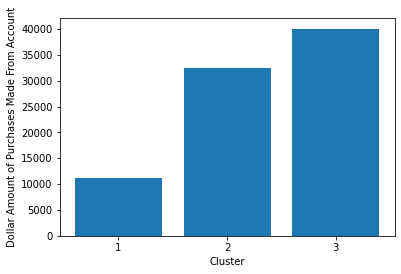

In [0]:
plt.bar(np.array(data.CLUSTER)+1,data.PURCHASES)
plt.xlabel('Cluster')
plt.ylabel('Dollar Amount of Purchases Made From Account')
plt.xticks([1,2,3]);

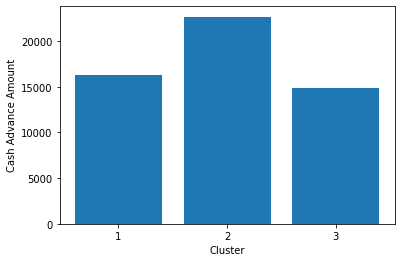

In [0]:
plt.bar(np.array(data.CLUSTER)+1,data.CASH_ADVANCE)
plt.xlabel('Cluster')
plt.ylabel('Cash Advance Amount')
plt.xticks([1,2,3]);

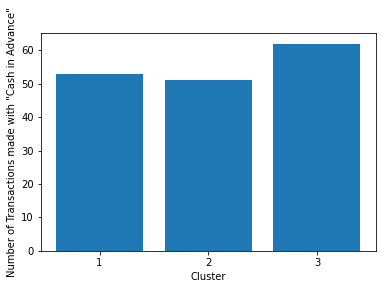

In [0]:
plt.bar(np.array(data.CLUSTER)+1,data.CASH_ADVANCE_TRX)
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions made with "Cash in Advance"')
plt.xticks([1,2,3]);

Cluster 1: Spends the least on the card, and uses cash advances moderately. Could call them "small spenders"     
Cluster 2: Spends more on the card, and takes out the highest cash advance amount. Could call them "medium spenders with large cash advances"      
Cluster 3: spends the most on the card, uses cash advances frequently but for smaller purchases. Could call them "big spenders"     


The credit card company can take the data about their customers, current and in the future, and put their information into this model to get a cluster label for each customer. Then the company can choose different marketing strategies based on the cluster descriptions above. This will result in more personalized marketing, and hopefully more revenue for the credit card company.